In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!mkdir '/content/data'
!unzip -qo 'imdb-dataset-of-50k-movie-reviews.zip' -d '/content/data'

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.22GB/s]


#### Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install contractions
from contractions import fix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Bidirectional, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Exploratory Data Analysis**

In [ ]:
# Load data
df = pd.read_csv('/content/data/IMDB Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
print(df.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 63.2+ MB
None


In [ ]:
print(df.describe())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


#### Class distribution analysis

- to check the target(sentiment) distribution

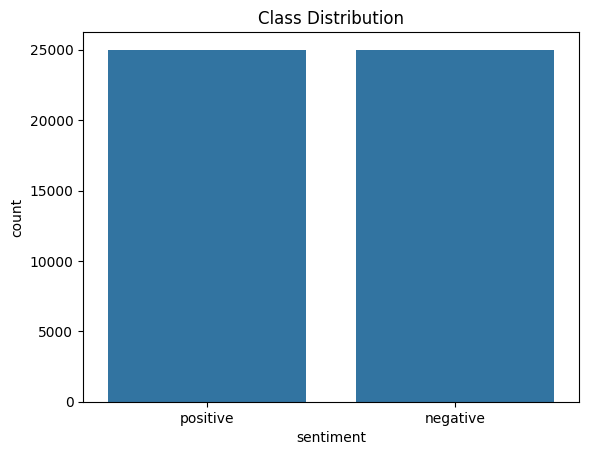

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution')
plt.show()

#### Text length distribution

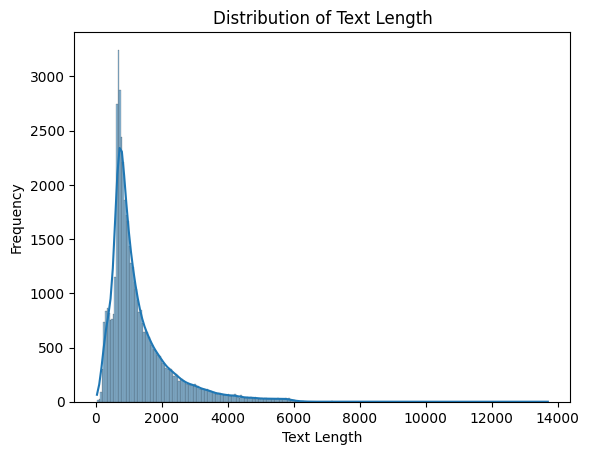

In [ ]:
df['text_length'] = df['review'].apply(len)

sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(df.groupby('sentiment')['text_length'].describe())

             count        mean          std   min    25%    50%      75%  \
sentiment                                                                  
negative   25000.0  1294.06436   945.892669  32.0  706.0  973.0  1567.25   
positive   25000.0  1324.79768  1031.492627  65.0  691.0  968.0  1614.00   

               max  
sentiment           
negative    8969.0  
positive   13704.0  


**Text Length Analysis**

Text Length Statistics:
- The average length of negative reviews is approximately 1,294 characters.
- The average length of positive reviews is approximately 1,325 characters.
- The maximum length of negative reviews is 8,969 characters, while for positive reviews, it is 13,704 characters.
- Both sentiment classes have a similar distribution of text lengths, with some reviews being quite long.

#### Word count distribution
- analyse the number of words in each review

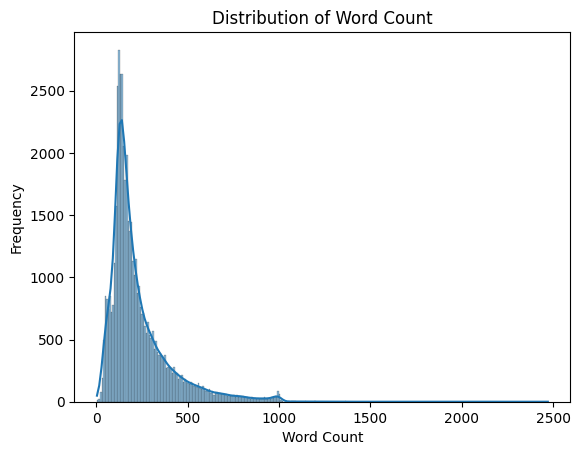

In [ ]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

- checking for the most common words in positive and negative reviews

Top words in positive reviews: [('the', 291927), ('and', 165943), ('a', 155775), ('of', 149178), ('to', 128343), ('is', 108168), ('in', 90427), ('that', 62449), ('I', 62223), ('it', 53378), ('this', 51614), ('/><br', 48976), ('as', 46574), ('with', 43291), ('was', 42155), ('for', 41076), ('The', 32911), ('but', 32342), ('his', 31695), ('on', 30605)]
Top words in negative reviews: [('the', 276808), ('a', 151185), ('and', 135976), ('of', 134447), ('to', 133507), ('is', 94888), ('in', 79554), ('I', 70275), ('that', 64369), ('this', 62112), ('it', 54538), ('/><br', 51998), ('was', 50503), ('for', 39843), ('with', 39278), ('as', 36556), ('The', 34406), ('movie', 34392), ('but', 33940), ('on', 30592)]


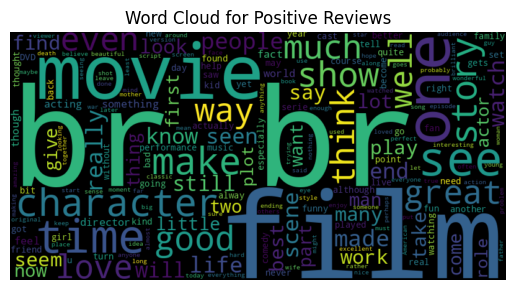

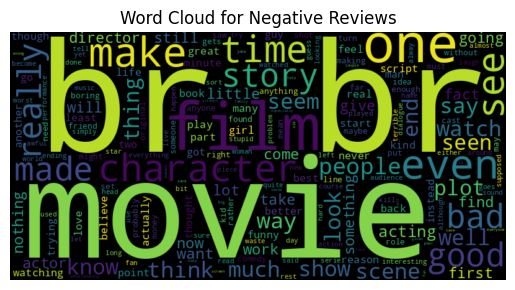

In [ ]:
positive_reviews = df[df['sentiment'] == 'positive']['review']
negative_reviews = df[df['sentiment'] == 'negative']['review']

# get top 'n' words for each class
def get_top_words(reviews, n=20):
  all_words = ' '.join(reviews).split()
  return Counter(all_words).most_common(n)

print("Top words in positive reviews:", get_top_words(positive_reviews))
print("Top words in negative reviews:", get_top_words(negative_reviews))

# word cloud for positive reviews
wordcloud = WordCloud(width=800, height=400).generate(' '.join(positive_reviews))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# word cloud for negative reviews
wordcloud = WordCloud(width=800, height=400).generate(' '.join(negative_reviews))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()


In [ ]:
from collections import Counter
import nltk
nltk.download('punkt')

all_words = ' '.join(df['review']).split()
word_freq = Counter(all_words)
print(word_freq.most_common(20))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('the', 568735), ('a', 306960), ('and', 301919), ('of', 283625), ('to', 261850), ('is', 203056), ('in', 169981), ('I', 132498), ('that', 126818), ('this', 113726), ('it', 107916), ('/><br', 100974), ('was', 92658), ('as', 83130), ('with', 82569), ('for', 80919), ('The', 67317), ('but', 66282), ('on', 61197), ('movie', 60762)]


**Common Words**

**Top Words in Positive Reviews:**
- Common words like "the", "and", "a", "of", "to", etc., are frequent.
- The presence of HTML tags like /><br suggests that the reviews contain HTML formatting that might need to be cleaned.

**Top Words in Negative Reviews:**
- Similar common words appear, but the frequency of words like "movie" is higher in negative reviews, which might indicate a focus on specific aspects of the movie.

**Interesting differences:**

- 'movie' appears more in negative reviews (34,392 vs not in positive top 20)

- Positive reviews use more conjunctions ('and' appears 30k more times)

- Negative reviews have more self-references ('I' appears 8k more times)

#### N-grams

In [ ]:
from nltk import bigrams, trigrams

bigram_freq = Counter(bigrams(all_words))
trigram_freq = Counter(trigrams(all_words))

print(bigram_freq.most_common(20))
print(trigram_freq.most_common(20))

[(('of', 'the'), 74969), (('in', 'the'), 45938), (('is', 'a'), 25709), (('and', 'the'), 23640), (('to', 'the'), 23037), (('to', 'be'), 22024), (('this', 'movie'), 17582), (('in', 'a'), 16541), (('on', 'the'), 16255), (('of', 'a'), 15299), (('for', 'the'), 14983), (('the', 'film'), 14808), (('with', 'the'), 14628), (('one', 'of'), 14494), (('/><br', '/>The'), 14335), (('the', 'movie'), 13994), (('is', 'the'), 13001), (('at', 'the'), 12574), (('this', 'film'), 12530), (('it', 'was'), 12147)]
[(('one', 'of', 'the'), 8645), (('a', 'lot', 'of'), 4302), (('is', 'one', 'of'), 3513), (('some', 'of', 'the'), 3108), (('to', 'be', 'a'), 3059), (('of', 'the', 'film'), 2842), (('this', 'movie', 'is'), 2711), (('of', 'the', 'movie'), 2557), (('the', 'fact', 'that'), 2425), (('the', 'film', 'is'), 2344), (('this', 'is', 'a'), 2105), (('This', 'is', 'a'), 2090), (('this', 'film', 'is'), 2041), (('of', 'the', 'most'), 2031), (('rest', 'of', 'the'), 2027), (('the', 'movie', 'is'), 2026), (('the', 'rest'

**N-gram Analysis**

**Bigrams:**

- Most are syntactic combinations ('of the', 'in the')

Some sentiment indicators:

- 'this movie', 'this film' (often in negative contexts)

- 'to be' (could signal opinions)

**Trigrams:**

- 'one of the' (commonly starts opinions)

- 'a lot of' (could signal intensity)

Sentiment phrases:

- 'this movie is'

- 'the fact that' (often precedes criticism)

- 'is one of'

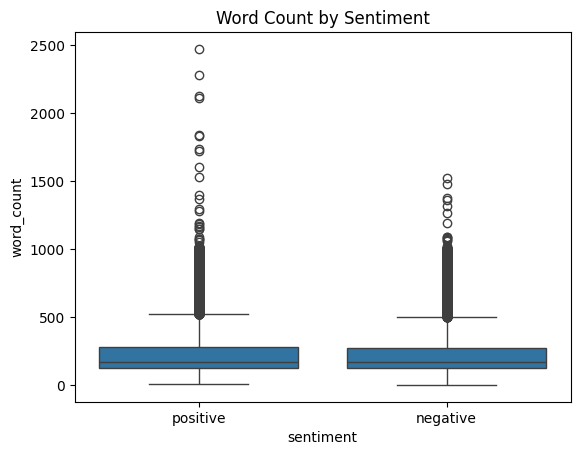

In [ ]:
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Word Count by Sentiment')
plt.show()

In [ ]:
print(df.isnull().sum())

review         0
sentiment      0
text_length    0
word_count     0
dtype: int64


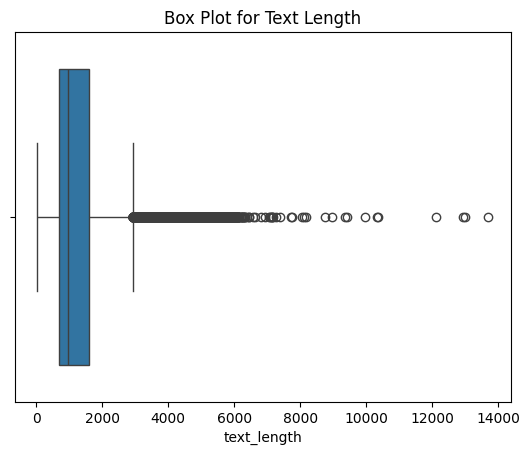

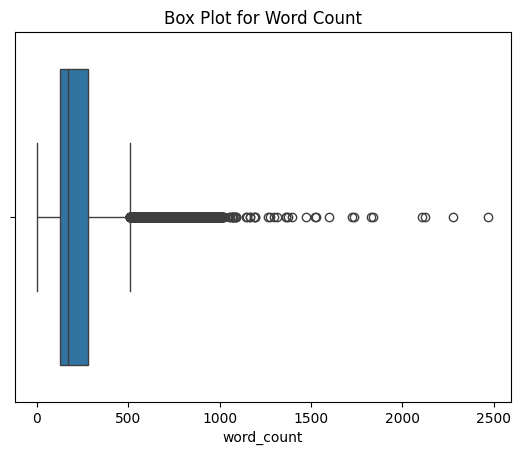

In [ ]:
sns.boxplot(x=df['text_length'])
plt.title('Box Plot for Text Length')
plt.show()

sns.boxplot(x=df['word_count'])
plt.title('Box Plot for Word Count')
plt.show()

In [ ]:
df.head()

,review,sentiment,text_length,word_count
0,One of the other reviewers has mentioned that ...,positive,1761,307
1,A wonderful little production. <br /><br />The...,positive,998,162
2,I thought this was a wonderful way to spend ti...,positive,926,166
3,Basically there's a family where a little boy ...,negative,748,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,230


In [ ]:
df.drop(columns=['text_length', 'word_count'], inplace=True)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## **Preprocessing**

- HTML cleaning
- Stop words: need careful handling; complete removal might lose
  - Negations ("not good" if 'not' is removed, it chanes the meaning)
  - Contrastive conjunctions ("but" is important for sentiment shifts)
- Special tokens: May want to keep:
  - Exclamation points (more common in positive reviews)
  - Question marks (might indicate negative uncertaininty)
- Length considerations: some very long reviews may need truncation
- Case sensitivity
- Contractions
- Negation handling

### **Preprocessing for Traditional ML Models**



**Preprocessing**

1. HTML and special character handling

2. Contraction expansion

3. Lowercasing + Stopword filtering with a custom keeplist (on keeping sentiment-heavy words like not, but)

4. Lemmatization

5. Negation handling with not_ + word combos — that's a great trick that helps traditional models "feel" polarity

In [ ]:
# Initialize stopwords with custom keeplist
STOPWORDS = set(stopwords.words('english'))
KEEP_WORDS = {'not', 'no', 'but', 'very', 'too', 'just', 'only', 'nor'}
STOPWORDS = STOPWORDS - KEEP_WORDS

lemmatizer = WordNetLemmatizer()

def ml_preprocess(text):
  # remove HTML tags
  text = re.sub(r'<[^>]+>', '', text)
  # handle special characters and numbers
  text = re.sub(r'[^a-zA-Z\s!?]', '', text)
  # expand contractions
  text = fix(text)
  # lowercasing
  text = text.lower()
  # tokenize with custom stopwrod remover
  tokens = [word for word in word_tokenize(text)
            if word not in STOPWORDS]
  # lemmatization
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  # handle negations (eg, 'not good' - 'not_good')
  processed = []
  for i, word in enumerate(tokens):
    if word in ['not', 'no'] and i+1 < len(tokens):
      # Append the combined negation and subsequent word
      processed.append(f"{word}_{tokens[i+1]}")
      # Skip the next word since it's already processed with the negation
      tokens[i+1] = None # Mark as None to skip in the next iteration
    elif word is not None: # Only process if the word hasn't been skipped
      processed.append(word)

  return ' '.join(processed)


df['ml_processed'] = df['review'].apply(ml_preprocess)

In [ ]:
print("Original:", df['review'].iloc[0])
print("Processed:", df['ml_processed'].iloc[0])

Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due 

#### **Feature engineering with TF-IDF, N-Grams**

1. Data splitting before engineering to avoid data leakage
2. Added 'stratify' to maintain class balance
3. Safe vectorization
  - 'fit_transform()' only on training data - learns the vocabulary and document frequencies
  - 'transform() on test data (no fitting) - applies these learned stats
  
  **why?**
  - to avoid data leakage - test data should never influence feature creation

  *what would happen if we fit on full data?*
  - test performance metrics would be artificially inflated
  - the model would appear better than it truly is

In [ ]:
# train-test split to avoid leakage
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment'] # for class balance
)

# vectorization
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=15000,
    min_df=5,
    max_df=0.7,
    stop_words=list(STOPWORDS)
)

# Fit and transform training data
X_train = tfidf.fit_transform(train_df['ml_processed'])
# Transform test data (no fitting!)
X_test = tfidf.transform(test_df['ml_processed'])

# Convert labels to numeric
y_train = train_df['sentiment'].map({'positive': 1, 'negative': 0})
y_test = test_df['sentiment'].map({'positive': 1, 'negative': 0})

#### **Model Training and Evaluation**

In [ ]:
# Model training
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        C=0.5,
        class_weight='balanced',
        random_state=42
    ),
    "SVM": SVC(
        kernel='linear',
        C=0.1,
        class_weight='balanced',
        random_state=42
    )
}

results = {}
for name, model in models.items():
  model.fit(X_train, y_train)  #train

  y_pred = model.predict(X_test)   # predict

  # evaluate
  results[name] = {
      'accuracy': accuracy_score(y_test, y_pred),
      'f1': f1_score(y_test, y_pred),
      'classification_report': classification_report(y_test, y_pred)
  }

# Results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print("\nClassification Report:")
    print(metrics['classification_report'])


Logistic Regression Results:
Accuracy: 0.8968
F1 Score: 0.8980

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


SVM Results:
Accuracy: 0.8935
F1 Score: 0.8954

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      5000
           1       0.88      0.91      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# Compare with cross-validation (on training set only)
from sklearn.model_selection import cross_val_score
print("\nCross-validation scores (on training data):")
for name, model in models.items():
    cv_scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1
    )
    print(f"{name} CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Cross-validation scores (on training data):
Logistic Regression CV F1: 0.8935 (±0.0025)
SVM CV F1: 0.8905 (±0.0016)


**Cross-Validation Explained**

***What it does***
- divides training data into K folds (e.g., 5)
- trains on K-1 folds, validates on 1 fold
- rotates which fold is used for validation
- averages results across folds

***Why we use it***
1. better estimate of real performance than single train-test split
2. uses all training data for both training and validation
3. identifies stability of model (via standard deviation)

### **Preprocessing for Deep Learning models**

Preprocessing for Deep Learning models is a bit less aggressive than for the traditional machine learning models with some key differences

1. Text cleaning
- Traditional ML - aggressive (stopwords, lemmatization)
- DL - minimal to preserve raw information
2. Case handling
- Trad - always lowercase
- DL - could be optional
3. Tokenization
- Trad - word-level
- DL - subword or word-level
4. Negation handling
- Trad - manual (not_good)
- DL - let model learn patterns
5. Sequence length
- Trad - irrelevant
- DL - critical (padding/truncation)
6. Vocabulary
- Trad - limited by TF-IDF
- DL - full vocabulary with OOV handling

In [ ]:
df_dl = df.copy()  # start fresh

In [ ]:
def dl_preprocess(text):
    text = re.sub(r'<br\s*/?>', ' ', text)  # Replace <br> with space
    text = re.sub(r'<[^>]+>', '', text)  # then remove other HTML
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = fix(text)  # Expand contractions
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()  # Minimal whitespace cleanup

# Apply preprocessing
df_dl['dl_processed'] = df_dl['review'].apply(dl_preprocess)


In [ ]:
print("Original:", df_dl['review'].iloc[0])
print("DL Processed:", df_dl['dl_processed'].iloc[0])

Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due 

#### **Tokenization and Sequence Preparation**

**Tokenizer fit on the entire dataset**

- deep learning models need consistent vocabulary mapping
- the tokenizer only maps words to indices (no statistical calculations)
- doesn't expose the model to test set labels/patterns
- it is standard practice in NLP
- Tokenization ≠ feature weighting

In [ ]:
# initialize tokenizer
VOCAB_SIZE = 10000
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE + 1,
    oov_token="<OOV>",
    filters='',
    lower=False
)

# fit on entire dataset
tokenizer.fit_on_texts(df_dl['dl_processed'])

# convert text to sequences
sequences = tokenizer.texts_to_sequences(df_dl['dl_processed'])

# analyse sequence lengths
seq_lengths = [len(seq) for seq in sequences]
print(pd.Series(seq_lengths).describe())

# set max length
MAX_LEN = 500

# pad sequences
X_dl = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

# labels
y_dl = df_dl['sentiment'].map({'positive':1, 'negative':0}).values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_dl, y_dl, test_size=0.2, random_state=42
)

count    50000.000000
mean       231.164360
std        170.974802
min          4.000000
25%        127.000000
50%        173.000000
75%        280.000000
max       2472.000000
dtype: float64


In [ ]:
# Check what percentage of data you're losing
truncated_reviews = sum(1 for length in seq_lengths if length > 500)
print(f"Reviews truncated: {truncated_reviews/len(seq_lengths)*100:.1f}%")

Reviews truncated: 7.8%


#### **Model Training & Evaluation**

In [ ]:
def build_lstm_model():
  model = Sequential([
      Embedding(input_dim=20000, output_dim=128, input_length=MAX_LEN),
      LSTM(64, dropout=0.2),
      Dense(1, activation='sigmoid')
  ])
  return model

def build_gru_model():
  model = Sequential([
      Embedding(input_dim=20000, output_dim=128, input_length=MAX_LEN),
      Bidirectional(GRU(64, dropout=0.2)),
      Dense(1, activation='sigmoid')
  ])
  return model

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name='Model'):
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  history = model.fit(
      X_train, y_train,
      epochs=10,
      batch_size=128,
      validation_split=0.2,
      callbacks=[early_stop],
      verbose=1
  )

  # predict
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob > 0.5).astype(int)

  # metrics
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f"\n {model_name} Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
  print(classification_report(y_test, y_pred, digits=4))

  # plot
  plt.figure(figsize=(10, 4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title(f'{model_name} Training History')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.4984 - loss: 0.6938 - val_accuracy: 0.5073 - val_loss: 0.6928
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.5119 - loss: 0.6905 - val_accuracy: 0.5006 - val_loss: 0.6965
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.5310 - loss: 0.6693 - val_accuracy: 0.4988 - val_loss: 0.7068
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.5391 - loss: 0.6483 - val_accuracy: 0.5073 - val_loss: 0.7270
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step

 LSTM Accuracy: 0.5015 | F1 Score: 0.1451
              precision    recall  f1-score   support

           0     0.4987    0.9256    0.6482      4961
           1     0.5341    0.0839    0.1451      5039

    accuracy                         0.5015     10000
   macro avg     0.5164    0.5048    0.3966     10000
weighted avg     0.5165    0.5015    0.3947     10000



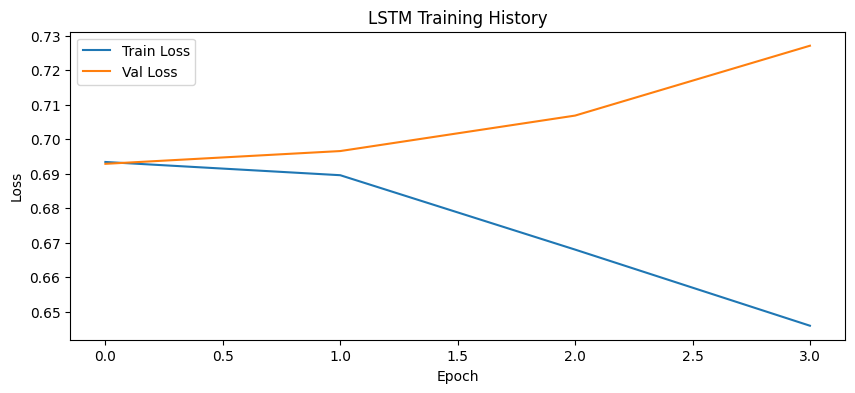

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 753s 3s/step - accuracy: 0.6235 - loss: 0.6221 - val_accuracy: 0.8177 - val_loss: 0.4159
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.8626 - loss: 0.3355 - val_accuracy: 0.8644 - val_loss: 0.3411
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 598s 2s/step - accuracy: 0.9166 - loss: 0.2250 - val_accuracy: 0.8530 - val_loss: 0.3763
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 619s 2s/step - accuracy: 0.9457 - loss: 0.1565 - val_accuracy: 0.8755 - val_loss: 0.3430
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.9664 - loss: 0.1063 - val_accuracy: 0.8505 - val_loss: 0.4051
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 176ms/step

 BiGRU Accuracy: 0.8626 | F1 Score: 0.8620
              precision    recall  f1-score   support

           0     0.8528    0.8738    0.8632      4961
           1     0.8727    0.8516    0.8620      5039

    accuracy                         0.8626     10000
   macro avg     0.8628    0.8627    0.8626     10000
weight

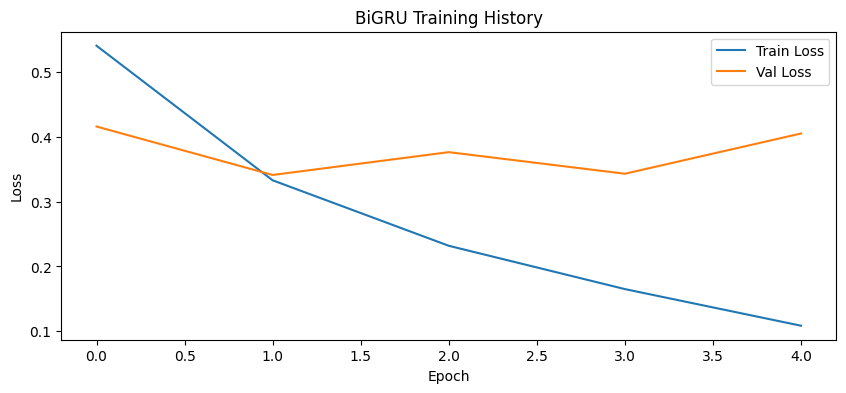

In [ ]:
# LSTM
lstm_model = build_lstm_model()
train_and_evaluate(lstm_model, X_train, y_train, X_test, y_test, model_name='LSTM')

# GRU
gru_model = build_gru_model()
train_and_evaluate(gru_model, X_train, y_train, X_test, y_test, model_name='BiGRU')

**Basic LSTM Results**

- Train Loss (Blue): Decreased from ~0.73 to 0.65

- Val Loss (Orange): Stagnated around ~0.69-0.70

**Key problems**
1. underfitting - both losses are hig and not decreasing sufficiently
2. no generalization - validation loss isn't improving despite train loss decreasing
3. early stopping triggered at epoch 4


**Classification report**
- The model collapsed into predicting mostly negative class (92.6% of the time)

- This explains near-50% accuracy (balanced dataset) and terrible F1

**possible fixes**
- embedding layer - input_dim=20000 is too large fordataset size
; try reducing to 5000-10000

- LSTM layer- 64 units may be too insufficient

- optimization - no learning rate; default Adam may be too aggressive
- try reduce batch size from 128 to 32/64

**Bi-GRU results:**

- early signs of overfitting, after epoch 2, training metrics keep improving while validation stalls
- early stopping correctly triggered at epoch 5
- better recall especially for the positive class compared to the basic LSTM
- a balanced performance with <2% difference between precision/ recall across classes
- test accuracy matches validation accuracy
- all in all the BiGRU handles the task better than the basic LSTM

### **Bi-GRU**

**Key differences:**
Embedding Layer:

- Reduce input_dim from 20000 to 10000 (based on word frequency)

= Add mask_zero=True to handle padding more efficiently

GRU Configuration:

- Consider stacking another GRU layer (64-32 units)

- Add recurrent_dropout=0.1 for better regularization

Training Process:

- Lower batch size (128 - 64/32) for better gradient estimates

- Add learning rate reduction callback

#### **Model 2**

In [ ]:
def build_enhanced_gru():
    model = Sequential([
        Embedding(VOCAB_SIZE + 1, 128, mask_zero=True),
        Bidirectional(GRU(64, return_sequences=True, dropout=0.2)),
        Bidirectional(GRU(32, dropout=0.2)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=5),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

model = build_enhanced_gru()

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 1402s 3s/step - accuracy: 0.7184 - loss: 0.5161 - precision: 0.7040 - recall: 0.7745 - val_accuracy: 0.8706 - val_loss: 0.3077 - val_precision: 0.9108 - val_recall: 0.8217 - learning_rate: 0.0010
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 1382s 3s/step - accuracy: 0.9080 - loss: 0.2346 - precision: 0.9085 - recall: 0.9082 - val_accuracy: 0.8961 - val_loss: 0.2618 - val_precision: 0.8871 - val_recall: 0.9078 - learning_rate: 0.0010
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 1370s 3s/step - accuracy: 0.9458 - loss: 0.1498 - precision: 0.9449 - recall: 0.9471 - val_accuracy: 0.9014 - val_loss: 0.2706 - val_precision: 0.9055 - val_recall: 0.8963 - learning_rate: 0.0010
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 1414s 3s/step - accuracy: 0.9659 - loss: 0.1010 - precision: 0.9653 - recall: 0.9663 - val_accuracy: 0.8894 - val_loss: 0.2897 - val_precision: 0.8815 - val_recall: 0.8997 - learning_rate: 0.0010
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 1402s 3s/step - 

KeyboardInterrupt: 

In [ ]:
%load_ext cudf.pandas

#### **Model 3**

In [ ]:
def build_simple_gru():
  model = Sequential([
      Embedding(VOCAB_SIZE + 1, 64, mask_zero=True),
      Bidirectional(GRU(32, dropout=0.3, recurrent_dropout=0.3)),
      Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy',
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall')]
  )
  return model

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

model = build_simple_gru()
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,  # doubled batch size
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.6366 - loss: 0.6160 - precision: 0.6206 - recall: 0.7344 - val_accuracy: 0.8267 - val_loss: 0.3818 - val_precision: 0.8306 - val_recall: 0.8210 - learning_rate: 0.0010
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.8621 - loss: 0.3353 - precision: 0.8566 - recall: 0.8666 - val_accuracy: 0.8466 - val_loss: 0.3455 - val_precision: 0.8332 - val_recall: 0.8668 - learning_rate: 0.0010
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.9002 - loss: 0.2567 - precision: 0.9002 - recall: 0.8990 - val_accuracy: 0.8413 - val_loss: 0.3532 - val_precision: 0.8725 - val_recall: 0.7993 - learning_rate: 0.0010
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.9171 - loss: 0.2218 - precision: 0.9179 - recall: 0.9149 - val_accuracy: 0.8546 - val_loss: 0.3372 - val_precision: 0.8579 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accur

##### **Visualization & Evaluation**

Starting comprehensive model evaluation...

1. Plotting training history...


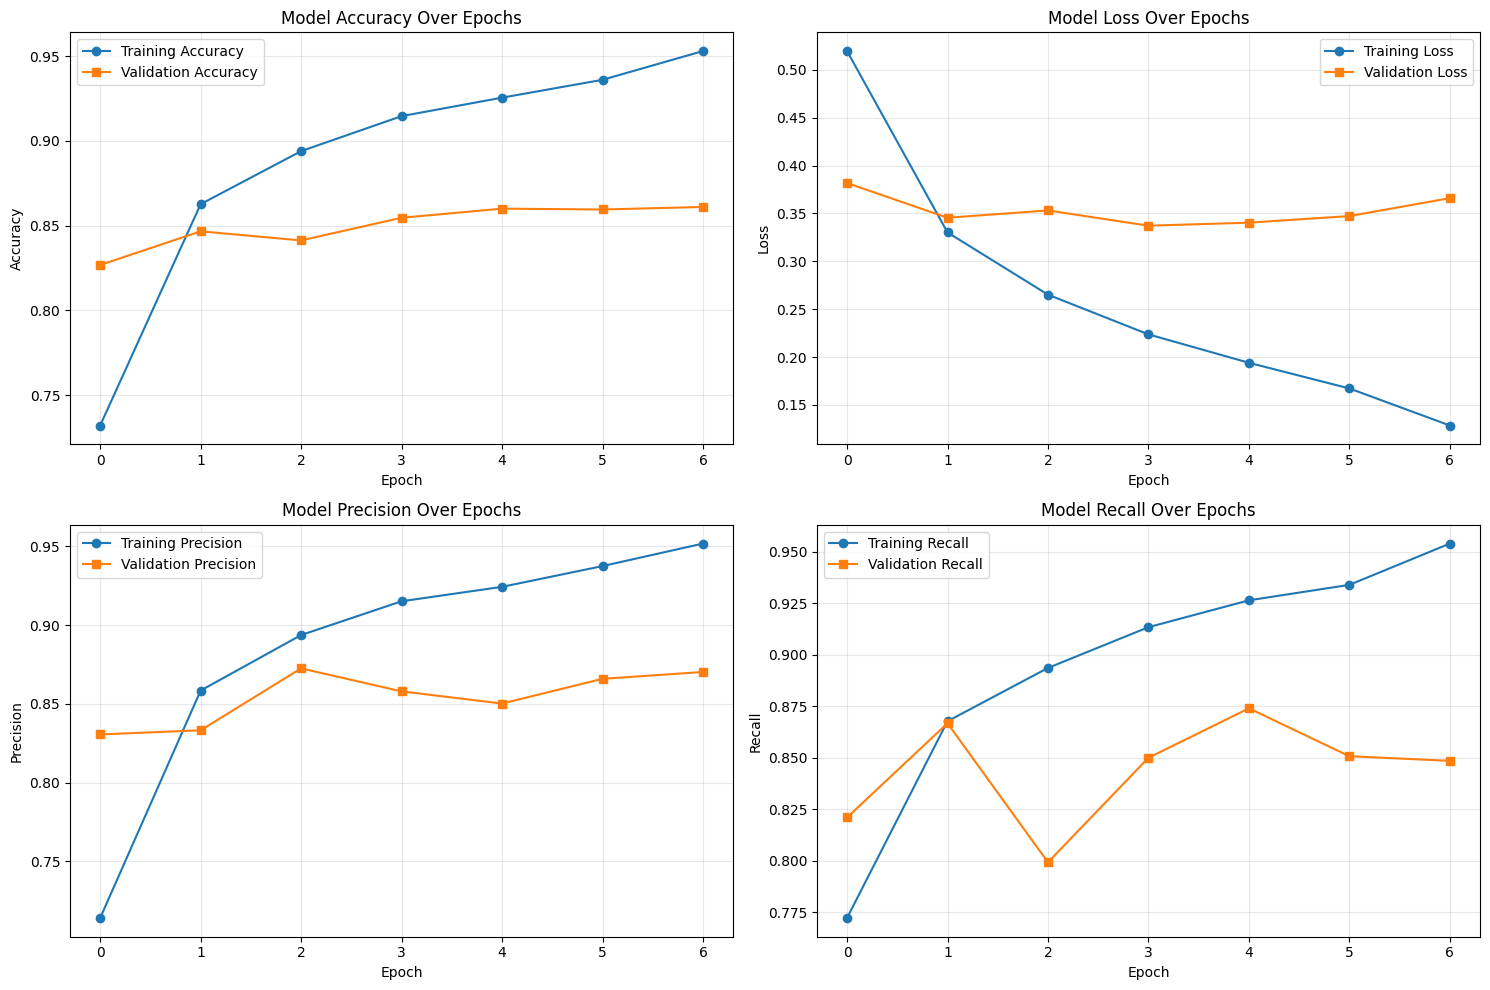


2. Calculating test metrics...
313/313 ━━━━━━━━━━━━━━━━━━━━ 179s 570ms/step
MODEL EVALUATION RESULTS
Test Accuracy: 0.8600
F1-Score: 0.8599
AUC-ROC Score: 0.9344

CLASSIFICATION REPORT:
------------------------------
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      4961
    Positive       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


3. Generating confusion matrix...


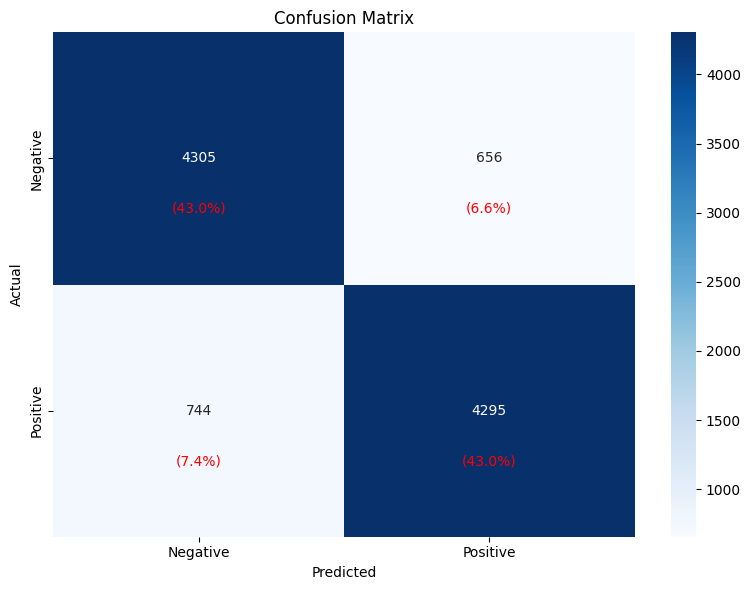


CONFUSION MATRIX ANALYSIS:
------------------------------
True Negatives (TN): 4305
False Positives (FP): 656
False Negatives (FN): 744
True Positives (TP): 4295
Total Samples: 10000

4. Plotting ROC curve...


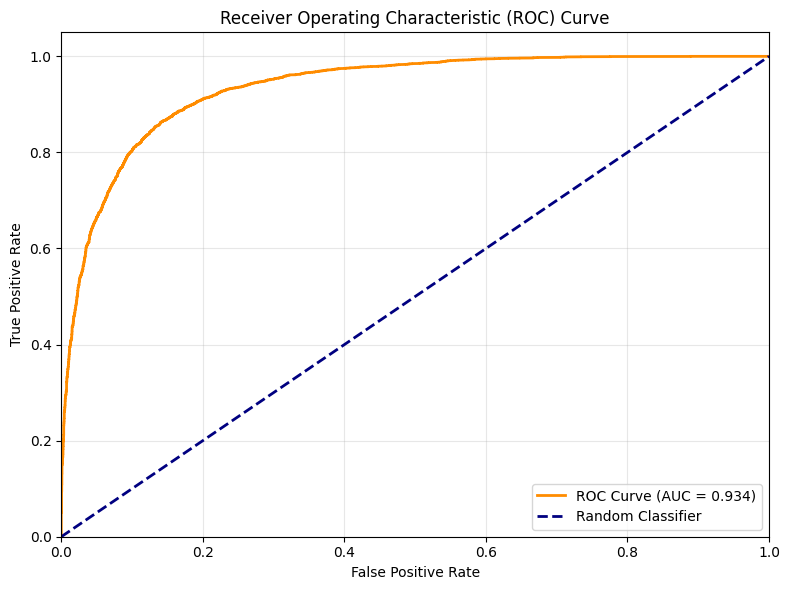


5. Analyzing overfitting patterns...

OVERFITTING ANALYSIS:
Training completed after 7 epochs
Final Training Accuracy: 0.9530
Final Validation Accuracy: 0.8610
Accuracy Gap: 0.0920

Best Validation Accuracy: 0.8610 (Epoch 7)
Best Validation Loss: 0.3372 (Epoch 4)

OVERFITTING INDICATORS:
-------------------------
 HIGH ACCURACY GAP: Significant overfitting detected
VALIDATION LOSS INCREASING: Model overfitting

PERFORMANCE SUMMARY & RECOMMENDATIONS
Overall Performance: GOOD
Key Metrics: Accuracy=0.860, F1=0.860, AUC=0.934

RECOMMENDATIONS:
--------------------
 OVERFITTING SOLUTIONS:
   • Increase dropout rate (0.3 → 0.4)
   • Add regularization (L1/L2)
   • Reduce model complexity
   • Increase training data
   • Early stopping with patience=2-3
 PERFORMANCE IMPROVEMENTS:
   • Try different architectures (LSTM, CNN)
   • Increase vocabulary size
   • Better text preprocessing
   • Ensemble methods
   • Hyperparameter tuning

 NEXT STEPS:
   1. Try simpler architecture to reduce overf

In [ ]:

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[0,0].set_title('Model Accuracy Over Epochs')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Loss
    axes[0,1].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[0,1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[0,1].set_title('Model Loss Over Epochs')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Precision
    axes[1,0].plot(history.history['precision'], label='Training Precision', marker='o')
    axes[1,0].plot(history.history['val_precision'], label='Validation Precision', marker='s')
    axes[1,0].set_title('Model Precision Over Epochs')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Recall
    axes[1,1].plot(history.history['recall'], label='Training Recall', marker='o')
    axes[1,1].plot(history.history['val_recall'], label='Validation Recall', marker='s')
    axes[1,1].set_title('Model Recall Over Epochs')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model_comprehensive(model, X_test, y_test):
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print("="*50)
    print("MODEL EVALUATION RESULTS")
    print("="*50)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print()

    # Classification Report
    print("CLASSIFICATION REPORT:")
    print("-" * 30)
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    return y_pred, y_pred_proba

def plot_confusion_matrix(y_test, y_pred):
    """Plot confusion matrix with annotations"""
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Add percentage annotations
    total = np.sum(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)',
                    ha='center', va='center', fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

    # Print detailed confusion matrix analysis
    tn, fp, fn, tp = cm.ravel()
    print("\nCONFUSION MATRIX ANALYSIS:")
    print("-" * 30)
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    print(f"Total Samples: {total}")


def plot_roc_curve(y_test, y_pred_proba):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_overfitting(history):
    """Analyze overfitting patterns"""
    epochs = len(history.history['accuracy'])
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    best_val_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    min_val_loss = min(history.history['val_loss'])
    best_loss_epoch = history.history['val_loss'].index(min_val_loss) + 1

    print("\nOVERFITTING ANALYSIS:")
    print("="*40)
    print(f"Training completed after {epochs} epochs")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Accuracy Gap: {final_train_acc - final_val_acc:.4f}")
    print()
    print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_val_epoch})")
    print(f"Best Validation Loss: {min_val_loss:.4f} (Epoch {best_loss_epoch})")
    print()

    # Overfitting indicators
    acc_gap = final_train_acc - final_val_acc
    loss_trend = final_val_loss > min_val_loss

    print("OVERFITTING INDICATORS:")
    print("-" * 25)
    if acc_gap > 0.05:
        print(" HIGH ACCURACY GAP: Significant overfitting detected")
    elif acc_gap > 0.02:
        print("MODERATE ACCURACY GAP: Some overfitting present")
    else:
        print("LOW ACCURACY GAP: Minimal overfitting")

    if loss_trend:
        print("VALIDATION LOSS INCREASING: Model overfitting")
    else:
        print("VALIDATION LOSS STABLE: Good generalization")


def performance_summary_and_recommendations(history, accuracy, f1, auc_score):
    """Provide performance summary and improvement recommendations"""
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY & RECOMMENDATIONS")
    print("="*60)

    # Performance Classification
    if accuracy >= 0.90:
        performance_level = "EXCELLENT"
    elif accuracy >= 0.85:
        performance_level = "GOOD"
    elif accuracy >= 0.80:
        performance_level = "MODERATE"
    else:
        performance_level = "NEEDS IMPROVEMENT"

    print(f"Overall Performance: {performance_level}")
    print(f"Key Metrics: Accuracy={accuracy:.3f}, F1={f1:.3f}, AUC={auc_score:.3f}")

    # Specific recommendations based on training patterns
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    acc_gap = final_train_acc - final_val_acc

    print("\nRECOMMENDATIONS:")
    print("-" * 20)

    if acc_gap > 0.05:
        print(" OVERFITTING SOLUTIONS:")
        print("   • Increase dropout rate (0.3 → 0.4)")
        print("   • Add regularization (L1/L2)")
        print("   • Reduce model complexity")
        print("   • Increase training data")
        print("   • Early stopping with patience=2-3")

    if accuracy < 0.87:
        print(" PERFORMANCE IMPROVEMENTS:")
        print("   • Try different architectures (LSTM, CNN)")
        print("   • Increase vocabulary size")
        print("   • Better text preprocessing")
        print("   • Ensemble methods")
        print("   • Hyperparameter tuning")

    if f1 < 0.85:
        print(" F1-SCORE IMPROVEMENTS:")
        print("   • Address class imbalance")
        print("   • Adjust decision threshold")
        print("   • Use class weights")

    print("\n NEXT STEPS:")
    print("   1. Try simpler architecture to reduce overfitting")
    print("   2. Experiment with different hyperparameters")
    print("   3. Consider data augmentation techniques")
    print("   4. Test on additional datasets for robustness")

def complete_model_evaluation(model, history, X_test, y_test):
    """Run complete evaluation pipeline"""
    print("Starting comprehensive model evaluation...")

    # 1. Plot training history
    print("\n1. Plotting training history...")
    plot_training_history(history)

    # 2. Get predictions and calculate metrics
    print("\n2. Calculating test metrics...")
    y_pred, y_pred_proba = evaluate_model_comprehensive(model, X_test, y_test)

    # 3. Plot confusion matrix
    print("\n3. Generating confusion matrix...")
    plot_confusion_matrix(y_test, y_pred)

    # 4. Plot ROC curve
    print("\n4. Plotting ROC curve...")
    plot_roc_curve(y_test, y_pred_proba)

    # 5. Analyze overfitting
    print("\n5. Analyzing overfitting patterns...")
    analyze_overfitting(history)

    # 6. Provide recommendations
    accuracy = np.mean(y_pred == y_test)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    performance_summary_and_recommendations(history, accuracy, f1, auc_score)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_score': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }


# Run complete evaluation
results = complete_model_evaluation(model, history, X_test, y_test)

# Access results
print(f"Final accuracy: {results['accuracy']:.4f}")
print(f"Final F1-score: {results['f1_score']:.4f}")

#### **Model 4**

In [ ]:
def build_balanced_gru():
    model = Sequential([
        Embedding(VOCAB_SIZE + 1, 64, mask_zero=True),

        Bidirectional(GRU(
            32,                    # Reduced from 64 (fewer parameters)
            dropout=0.4,           # Increased from 0.2 (more regularization)
            recurrent_dropout=0.3, # Added recurrent dropout
            return_sequences=False # No stacking - simpler model
        )),

        # Dropout before final layer
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    # Compile with gradient clipping to prevent exploding gradients
    model.compile(
        optimizer=Adam(
            learning_rate=0.001,
            clipnorm=1.0  # Gradient clipping
        ),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    return model

In [ ]:
callbacks = [
    # Stop early if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=3,           # Reduced from 5 - stop sooner
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate more aggressively
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,          # Cut LR in half (more aggressive)
        patience=2,          # React faster to plateaus
        min_lr=1e-6,
        verbose=1
    )
]

model = build_balanced_gru()
history = model.fit(
    X_train, y_train,
    epochs=12,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,8
    verbose=1
)

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.6125 - loss: 0.6404 - precision: 0.6164 - recall: 0.5513 - val_accuracy: 0.8275 - val_loss: 0.3888 - val_precision: 0.8247 - val_recall: 0.8317 - learning_rate: 0.0010
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.8502 - loss: 0.3615 - precision: 0.8411 - recall: 0.8640 - val_accuracy: 0.8462 - val_loss: 0.3507 - val_precision: 0.8156 - val_recall: 0.8947 - learning_rate: 0.0010
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.8885 - loss: 0.2923 - precision: 0.8885 - recall: 0.8892 - val_accuracy: 0.8575 - val_loss: 0.3183 - val_precision: 0.8785 - val_recall: 0.8298 - learning_rate: 0.0010
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9060 - loss: 0.2447 - precision: 0.9050 - recall: 0.9069 - val_accuracy: 0.8620 - val_loss: 0.3187 - val_precision: 0.8593 - val_recall: 0.8658 - learning_rate: 0.0010
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accur

In [ ]:
model.evaluate(X_test, y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 575ms/step - accuracy: 0.8713 - loss: 0.2991 - precision: 0.8682 - recall: 0.8769


[0.3038298785686493, 0.8722000122070312, 0.871566891670227, 0.8753721117973328]

#### **Model 5 - With GloVe**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-06-07 16:56:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-07 16:56:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-07 16:56:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((VOCAB_SIZE + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i > VOCAB_SIZE:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
def build_glove_gru():
    model = Sequential([
        Embedding(
            input_dim=VOCAB_SIZE + 1,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=MAX_LEN,
            trainable=False,
            mask_zero=True
        ),
        Dropout(0.3),  # Optional additional regularization
        Bidirectional(GRU(
            32,
            dropout=0.4,
            recurrent_dropout=0.3,
            return_sequences=False
        )),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model


In [ ]:
callbacks = [
    # Stop early if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=3,           # Reduced from 5 - stop sooner
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate more aggressively
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,          # Cut LR in half (more aggressive)
        patience=2,          # React faster to plateaus
        min_lr=1e-6,
        verbose=1
    )
]

model = build_glove_gru()
history = model.fit(
    X_train, y_train,
    epochs=9,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/9
250/250 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.5263 - loss: 0.7320 - precision: 0.5272 - recall: 0.5255 - val_accuracy: 0.6609 - val_loss: 0.6320 - val_precision: 0.6313 - val_recall: 0.7735 - learning_rate: 0.0010
Epoch 2/9
250/250 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.6183 - loss: 0.6478 - precision: 0.6151 - recall: 0.6355 - val_accuracy: 0.7897 - val_loss: 0.4620 - val_precision: 0.7571 - val_recall: 0.8533 - learning_rate: 0.0010
Epoch 3/9
250/250 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.7242 - loss: 0.5479 - precision: 0.7193 - recall: 0.7397 - val_accuracy: 0.8123 - val_loss: 0.4100 - val_precision: 0.8201 - val_recall: 0.8000 - learning_rate: 0.0010
Epoch 4/9
250/250 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.7644 - loss: 0.4994 - precision: 0.7603 - recall: 0.7691 - val_accuracy: 0.8269 - val_loss: 0.3869 - val_precision: 0.8129 - val_recall: 0.8493 - learning_rate: 0.0010
Epoch 5/9
250/250 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 

In [ ]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 598ms/step - accuracy: 0.8616 - loss: 0.3187 - precision: 0.8818 - recall: 0.8369


[0.32609495520591736,
 0.8585000038146973,
 0.881313145160675,
 0.8311172723770142]

#### **Model 6 (in final notebook)**